In [47]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import scipy as sp

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.compose import TransformedTargetRegressor

import time
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
import re
import shap

from common import (
    CustomOneHotEncoder,
    apply_onehot_encoder,
    apply_custom_encoder,
    compare_pipelines,
    grid_search,
    get_linear_regression_scores,
    build_pipeline,
    plot_predictions,
    split,
)

In [98]:
pd.set_option("display.max_colwidth", None)

In [99]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,4.946624,Leisure,None,None,60.0,6.858920,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,5.015221,Leisure,ServiceFacility,Leisure,61.0,6.923655,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,5.980508,Leisure,None,None,43.0,7.860859,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,4.787609,Leisure,None,None,56.0,6.832163,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,5.244478,Leisure,ServiceFacility,Leisure,75.0,7.151450,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,ServiceFacility,47.54067,-122.37441,0.30103,4.261548,Leisure,None,None,NaN,5.969455,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1533,ServiceFacility,47.59625,-122.32283,0.30103,4.204147,Leisure,None,None,NaN,5.977850,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1534,ServiceFacility,47.63644,-122.35784,0.30103,4.119190,Leisure,ServiceFacility,Leisure,NaN,6.760867,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1535,ServiceFacility,47.52832,-122.32431,0.30103,4.149281,Leisure,ServiceFacility,School,NaN,5.857014,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


We will set aside a data set that contains energy star score information

In [100]:
energy_data = data.copy()
energy_data = energy_data.loc[~energy_data["ENERGYSTARScore"].isna()]

# Separation of training and test data

In [101]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

In [102]:
np.random.seed(42)

In [103]:
(X_train, X_test, y_train, y_test) = split(X, y_energy_use)

# Pipelines 

Getting a baseline measure with a naive model

In [104]:
mean_prediction = np.mean(y_train)
rmse_mean = np.sqrt(mean_squared_error(
    y_train, [mean_prediction] * len(y_train)))
print("Mean Prediction:", mean_prediction)
print("RMSE (Mean Model):", rmse_mean)

Mean Prediction: 6.493606618505547
RMSE (Mean Model): 0.5542735075126345


Getting a baseline measure with a LinearRegression model and OneHotEncoder

In [105]:
X_train_onehot, X_test_onehot = apply_onehot_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train_onehot, y_train, X_test_onehot, y_test)

Train R2 score:  0.6606777641396193
Train RMSE score:  0.32200867646008
Test R2 score:  0.4164732418596868
Test RMSE score:  0.4130802105064468


Getting a baseline measure with a LinearRegression model and a custom encoder that condenses all property use types to 6 features representing the categories

In [106]:
X_train_custom_encoder, X_test_custom_encoder = apply_custom_encoder(
    X_train, X_test, data
)

get_linear_regression_scores(
    X_train_custom_encoder, y_train, X_test_custom_encoder, y_test
)

Train R2 score:  0.6503266459796306
Train RMSE score:  0.3267851589522557
Test R2 score:  0.4505445843603121
Test RMSE score:  0.3999494575158267


The train results with OneHotEncoder are slightly better but the test scores are better using the custom encoder

### Testing pipelines

Let's compare the results of a LinearRegression on the train set using different categorical encoders and feature selectors

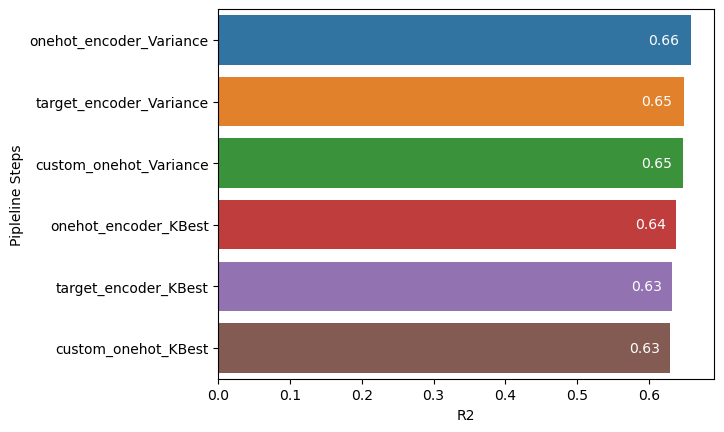

In [107]:
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses the custom OneHotEncoder, and the Variance feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

## Identifying optimal parameters with GridSearchCV

**Choice of metric**: 

For the grid search, we will compare three different metrics : R2, RMSE and MAE. 

R2 is easily interpretable, MAE is less impacted by outliers, and RMSE is stricter with large errors.

While we will be looking at all three metrics, we will take a closer look at RMSE, since we aim to predict GHG emissions and energy use and therefore limit the possibility of having large errors.

We will compare three pipelines, two of which will use a feature selector (Variance Threshold and SelectKBest) and one without a selector

In [58]:
model_comparison = pd.DataFrame()

In [59]:
kbest_params = {
    "selectkbest__k": [5, 7, 8, 10, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.3, 0.5, 0.7, 0.9]}

### Linear Regression

In [109]:
def linear_regression_grid_search(additional_params=None, selector=None):
    param_grid = {}
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_energy_use, LinearRegression(), param_grid, model_comparison, selector
    )


model_comparison = linear_regression_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
16,LinearRegression(),None,0.3268,0.66,0.2434,0.3220,{},0.02,0.11
1,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
2,LinearRegression(),SelectKBest(),0.3502,0.63,0.2522,0.3360,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.37
3,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
4,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
5,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
6,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
7,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
8,GradientBoostingRegressor(),VarianceThreshold(),0.5338,0.45,0.3085,0.4095,"{'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.18,368.70


In [108]:
model_comparison = linear_regression_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
15,LinearRegression(),SelectKBest(),0.3502,0.63,0.2522,0.3360,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.37
2,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
3,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
4,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
5,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
6,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
7,GradientBoostingRegressor(),VarianceThreshold(),0.5338,0.45,0.3085,0.4095,"{'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.18,368.70
8,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40


In [62]:
model_comparison = linear_regression_grid_search(
    variance_params, VarianceThreshold())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29


### SVR

#### Without selector

In [110]:
def svr_grid_search(additional_params=None, selector=None):
    param_grid = {
        "svr__C": [1, 3, 5, 100],
        "svr__epsilon": [1e-2, 0.5, 1, 2, 5, 10],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(X, y_energy_use, SVR(), param_grid, model_comparison, selector)


model_comparison = svr_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),None,0.3268,0.66,0.2434,0.3220,{},0.02,0.11
2,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
3,LinearRegression(),SelectKBest(),0.3502,0.63,0.2522,0.3360,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.37
4,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
5,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
6,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
7,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
8,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
9,GradientBoostingRegressor(),VarianceThreshold(),0.5338,0.45,0.3085,0.4095,"{'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.18,368.70


#### With SelectKBest Selector

In [111]:
model_comparison = svr_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),None,0.3268,0.66,0.2434,0.3220,{},0.02,0.11
2,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
3,LinearRegression(),SelectKBest(),0.3502,0.63,0.2522,0.3360,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.37
4,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
5,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
6,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
7,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
8,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
9,GradientBoostingRegressor(),VarianceThreshold(),0.5338,0.45,0.3085,0.4095,"{'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.18,368.70


#### With Variance Threshold Selector

In [65]:
model_comparison = svr_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
3,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
4,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
5,SVR(),VarianceThreshold(),0.5612,0.16,0.3984,0.5066,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.02,17.96


### ElasticNet

#### Without selector

In [66]:
def elastic_grid_search(additional_params=None, selector=None):
    param_grid = {
        "elasticnet__alpha": [1, 10, 15, 20],
        "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
        "elasticnet__max_iter": [3000],
        "elasticnet__random_state": [42],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_energy_use, ElasticNet(), param_grid, model_comparison, selector
    )


model_comparison = elastic_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
3,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
4,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
6,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
5,SVR(),VarianceThreshold(),0.5612,0.16,0.3984,0.5066,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.02,17.96


#### With SelectKBest selector

In [67]:
model_comparison = elastic_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
3,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
4,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
5,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
7,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27
6,SVR(),VarianceThreshold(),0.5612,0.16,0.3984,0.5066,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.02,17.96


#### With VarianceThreshold selector

In [68]:
model_comparison = elastic_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
3,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
4,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
5,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
6,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27
8,ElasticNet(),VarianceThreshold(),0.5608,0.05,0.4306,0.5388,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,11.43
7,SVR(),VarianceThreshold(),0.5612,0.16,0.3984,0.5066,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.02,17.96


### RandomForest

In [69]:
def random_forest_grid_search(additional_params=None, selector=None):
    param_grid = {
        "randomforestregressor__n_estimators": [50, 70, 100, 120],
        "randomforestregressor__min_samples_split": [2, 4, 6, 8],
        "randomforestregressor__max_features": ["sqrt", "log2", None],
        "randomforestregressor__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "randomforestregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_energy_use,
        RandomForestRegressor(),
        param_grid,
        model_comparison,
        selector,
    )

#### Without selector

In [70]:
model_comparison = random_forest_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
9,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
1,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
2,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
3,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
4,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
5,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
6,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27
7,ElasticNet(),VarianceThreshold(),0.5608,0.05,0.4306,0.5388,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,11.43
8,SVR(),VarianceThreshold(),0.5612,0.16,0.3984,0.5066,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.02,17.96


#### With SelectKBest selector

In [71]:
model_comparison = random_forest_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
2,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
10,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
3,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
4,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
5,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
6,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
7,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27
8,ElasticNet(),VarianceThreshold(),0.5608,0.05,0.4306,0.5388,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,11.43


#### With VarianceThreshold selector

In [72]:
model_comparison = random_forest_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
2,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
3,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
4,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
5,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
6,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
7,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
8,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27
9,ElasticNet(),VarianceThreshold(),0.5608,0.05,0.4306,0.5388,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,11.43


### Gradient Boosting

#### Without Selector

In [73]:
def gradient_boosting_grid_search(additional_params=None, selector=None):
    param_grid = {
        "gradientboostingregressor__n_estimators": [120, 150, 200],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
        ],
        "gradientboostingregressor__min_samples_split": [6, 8, 10],
        "gradientboostingregressor__max_features": ["sqrt", "log2", 1.0],
        "gradientboostingregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_energy_use,
        GradientBoostingRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = gradient_boosting_grid_search()

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
12,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
1,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
2,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
3,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
4,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
5,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
6,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
7,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37
8,ElasticNet(),SelectKBest(),0.5608,0.06,0.4292,0.5373,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,10.27


#### With SelectKBest Selector


In [74]:
model_comparison = gradient_boosting_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
2,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
13,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
3,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
4,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
5,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
6,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
7,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57
8,ElasticNet(),None,0.5608,0.06,0.4281,0.5361,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.02,3.37


#### With VarianceThreshold selector

In [75]:
model_comparison = gradient_boosting_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Train Mean R2,Train Mean MAE,Train Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.3268,0.66,0.2413,0.3205,{},0.02,0.17
1,GradientBoostingRegressor(),None,0.3332,0.66,0.2445,0.3213,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'log2', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.21,87.28
2,RandomForestRegressor(),None,0.3510,0.66,0.2448,0.3223,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.20,152.52
3,GradientBoostingRegressor(),SelectKBest(),0.3513,0.63,0.2538,0.3373,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.37,763.12
4,LinearRegression(),SelectKBest(),0.3546,0.62,0.2533,0.3392,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.01,0.39
5,RandomForestRegressor(),SelectKBest(),0.3792,0.61,0.2605,0.3445,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>}",0.32,1190.10
6,LinearRegression(),VarianceThreshold(),0.5091,0.44,0.3124,0.4155,{'variancethreshold__threshold': 0.9},0.01,0.29
14,GradientBoostingRegressor(),VarianceThreshold(),0.5338,0.45,0.3085,0.4095,"{'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.18,368.70
7,SVR(),None,0.5603,0.25,0.3746,0.4802,"{'svr__C': 1, 'svr__epsilon': 2}",0.01,2.40
8,SVR(),SelectKBest(),0.5603,0.26,0.3704,0.4772,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x14edefeb0>, 'svr__C': 1, 'svr__epsilon': 2}",0.05,35.57


# EnergyStarScore

In [76]:
y = energy_data["SiteEnergyUse(kBtu)"]
X_with_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
    ],
    axis=1,
)
X_without_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

(
    X_train_wo_score,
    X_test_wo_score,
    y_train_wo_score,
    y_test_wo_score,
) = train_test_split(X_without_score, y, test_size=0.2, random_state=42)

(
    X_train_with_score,
    X_test_with_score,
    y_train_with_score,
    y_test_with_score,
) = train_test_split(X_with_score, y, test_size=0.2, random_state=42)

### Testing with Gradient Boosting Regressor

First we get a baseline measure of our model without the EnergyStarScore

In [77]:
gradient_boosting = build_pipeline(
    GradientBoostingRegressor(
        loss="absolute_error",
        max_features="log2",
        n_estimators=120,
        random_state=42,
        min_samples_split=8,
    )
)

gradient_boosting.fit(X_train_wo_score, y_train_wo_score)
gradient_boosting.score(X_test_wo_score, y_test_wo_score)

0.7052164568715935

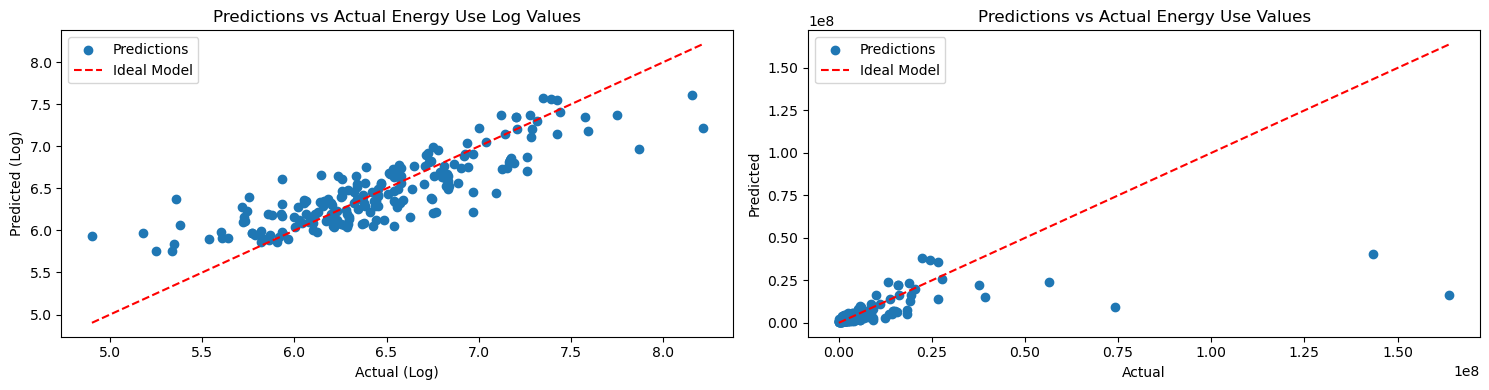

In [78]:
predictions = gradient_boosting.predict(X_test_wo_score)
plot_predictions(y_test_wo_score, predictions)

We can now compare it with the score of the model with the EnergyStarScore information

In [79]:
gradient_boosting.fit(X_train_with_score, y_train_with_score)
gradient_boosting.score(X_test_with_score, y_test_with_score)

0.7714191106047208

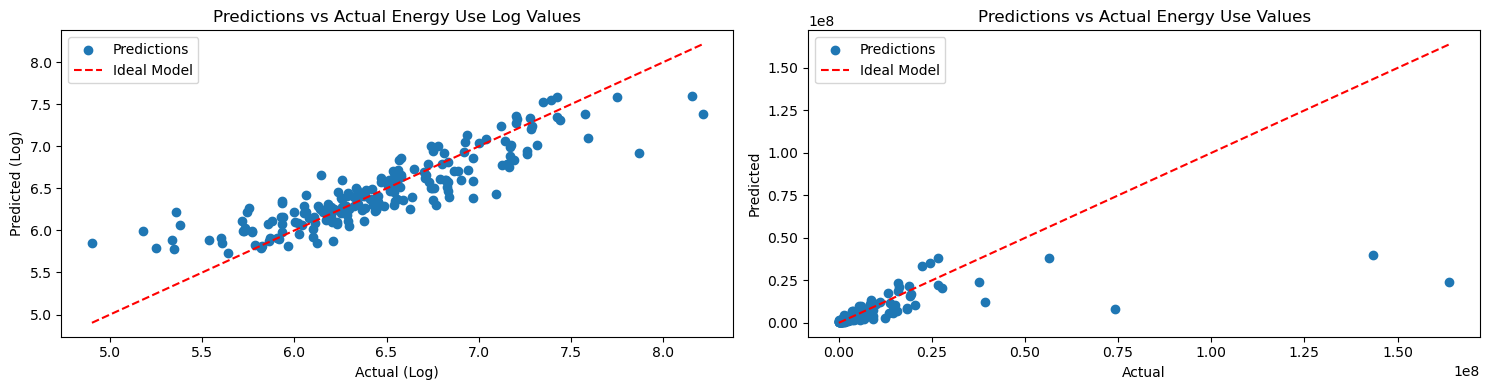

In [80]:
plot_predictions(y_test_with_score,
                 gradient_boosting.predict(X_test_with_score))

### Testing with Linear Regressor

In [112]:
linear_regression = build_pipeline(LinearRegression())

linear_regression.fit(X_train_wo_score, y_train_wo_score)
linear_regression.score(X_test_wo_score, y_test_wo_score)

0.7561881455101256

In [113]:
linear_regression.fit(X_train_with_score, y_train_with_score)
linear_regression.score(X_test_with_score, y_test_with_score)

0.8362640018992966

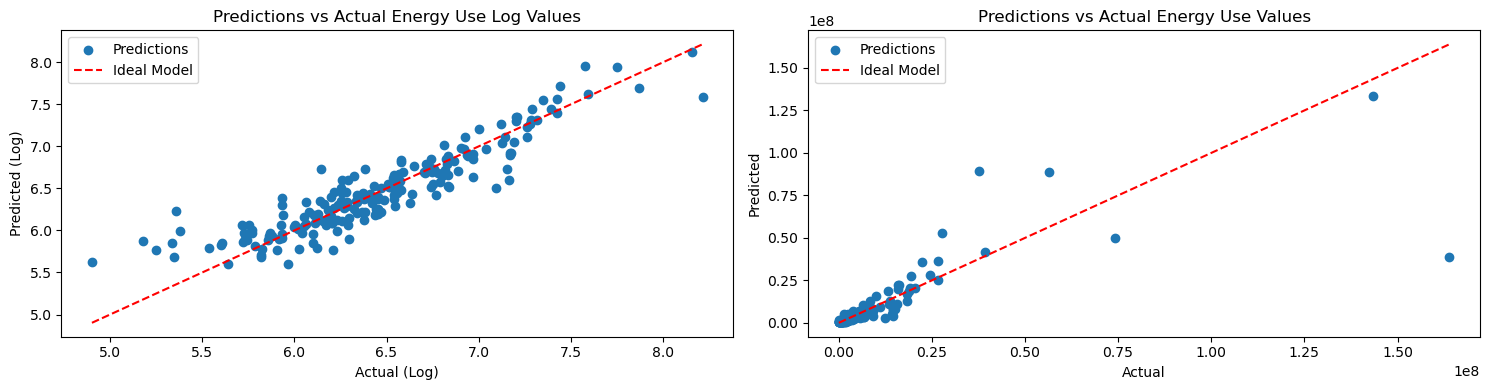

In [114]:
plot_predictions(y_test_with_score,
                 linear_regression.predict(X_test_with_score))

The EnergyStarScore related features do improve the Random Forest model with an R2 of about .8 

---

# Feature Importance

In [81]:
pipeline = make_pipeline(
    make_column_transformer(
        (
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            make_column_selector(dtype_include=object),
        ),
        remainder="passthrough",
    ),
    RobustScaler(),
)

In [82]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.fit_transform(X_test)

In [115]:
model = GradientBoostingRegressor(
    loss="absolute_error",
    max_features=1.0,
    min_samples_split=8,
    n_estimators=120,
    random_state=42,
)
model.fit(X_train_transformed, y_train)
model.score(X_test_transformed, y_test)

0.6603480682848906

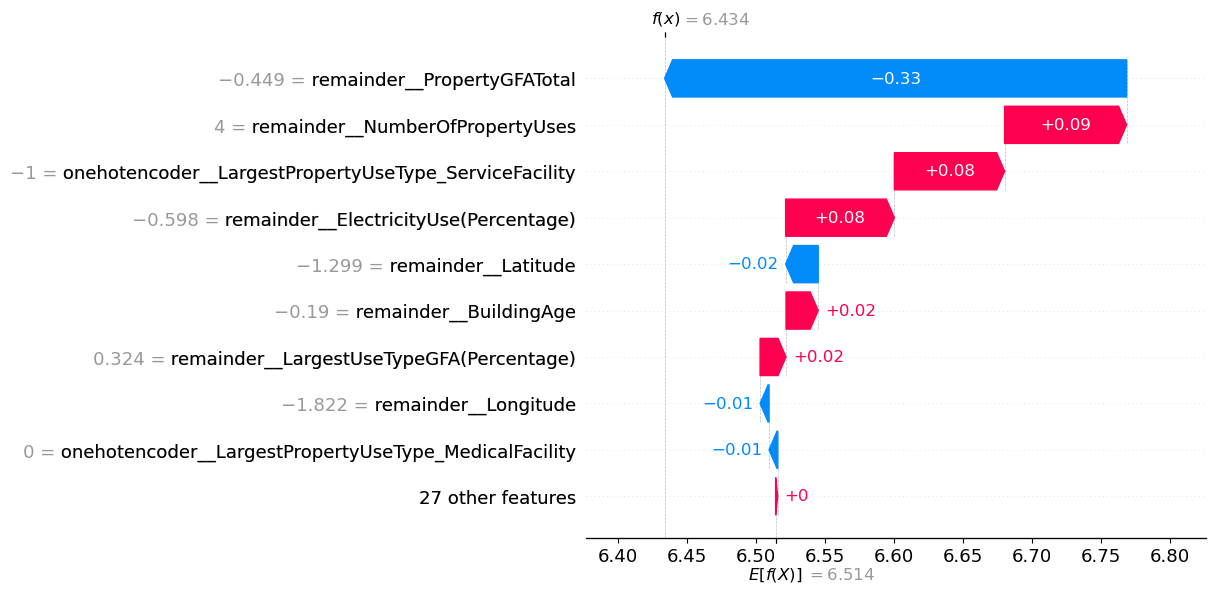

In [84]:
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(
    pd.DataFrame(X_test_transformed, columns=pipeline[:-1].get_feature_names_out())
)

shap.plots.waterfall(shap_values[0])

In [116]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
model.score(X_test_transformed, y_test)

0.6575908608695346

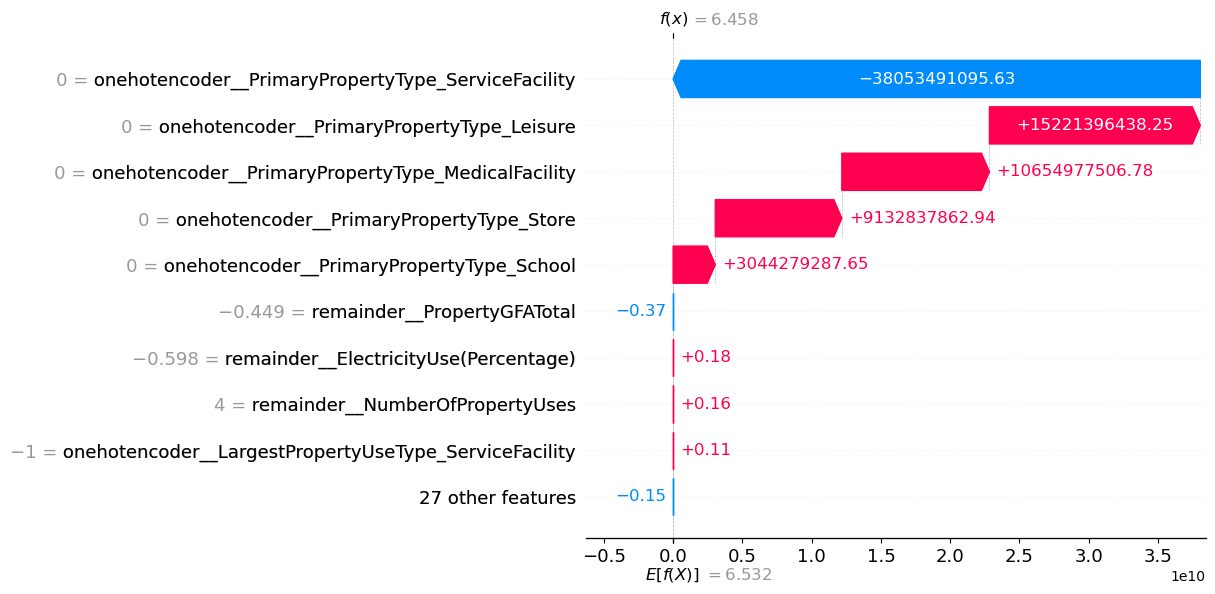

In [86]:
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(
    pd.DataFrame(X_test_transformed, columns=pipeline[:-1].get_feature_names_out())
)

shap.plots.waterfall(shap_values[0])